In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import Input

from bayes_opt import BayesianOptimization


In [2]:
# Load the dataset
df = pd.read_csv('Solar Power Plant Data.csv')
df.dropna(inplace=True)
df = df[(df['Radiation'] >= 0) & (df['SystemProduction'] >= 0)]
# Display basic info
df.head()


,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
11,01.01.2017-11:00,1.1,46,1005.8,49.7,-0.2,74,215.8333
12,01.01.2017-12:00,1.2,60,1006.1,138.7,1.8,72,831.6667
13,01.01.2017-13:00,0.4,59,1006.1,121.6,2.7,66,349.5000
14,01.01.2017-14:00,4.0,55,1006.5,77.0,5.0,49,272.0000
15,01.01.2017-15:00,2.7,26,1007.6,33.1,4.8,48,130.2083


In [ ]:
# Selecting features and target
features = ['Sunshine', 'AirTemperature', 'WindSpeed','RelativeAirHumidity','Radiation','AirPressure']  # Adjust as per your dataset
target = 'SystemProduction'

X = df[features]
y = df[target]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features + [target]])
df_scaled = pd.DataFrame(df_scaled, columns=features + [target], index=df.index)

X = df_scaled[features].values
y = df_scaled[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [9]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Metrics
print("XGBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("R2 Score:", r2_score(y_test, xgb_preds))


XGBoost:
RMSE: 0.11264363949730169
R2 Score: 0.4088549797990466


In [10]:
print(df['SystemProduction'].describe())


count    4296.000000
mean     1393.208439
std      1877.797255
min         0.000000
25%         0.000000
50%       489.833300
75%      2072.416725
max      7701.000000
Name: SystemProduction, dtype: float64


In [13]:
def xgb_evaluate(max_depth, learning_rate, n_estimators):
    model = XGBRegressor(max_depth=int(max_depth), learning_rate=learning_rate, n_estimators=int(n_estimators))
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={"max_depth": (3, 10), "learning_rate": (0.01, 0.3), "n_estimators": (50, 300)},
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=5, n_iter=10)

print("✅ Best parameters:", optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.3782    | 0.1186    | 9.655     | 233.0     |
| 2         | 0.4151    | 0.1836    | 4.092     | 89.0      |
| 3         | 0.4115    | 0.02684   | 9.063     | 200.3     |
| 4         | 0.3315    | 0.2153    | 3.144     | 292.5     |
| 5         | 0.3957    | 0.2514    | 4.486     | 95.46     |
| 6         | 0.3666    | 0.2482    | 3.3       | 74.66     |
| 7         | 0.3888    | 0.1109    | 6.267     | 192.4     |
| 8         | 0.3371    | 0.2456    | 5.662     | 207.8     |
| 9         | 0.4237    | 0.04907   | 7.015     | 90.99     |
| 10        | 0.4073    | 0.03406   | 9.933     | 86.63     |
| 11        | 0.3922    | 0.147     | 9.745     | 144.4     |
| 12        | 0.3928    | 0.1214    | 9.915     | 94.5      |
| 13        | 0.406     | 0.1963    | 3.905     | 134.8     |
| 14        | 0.3916    | 0.1629    | 9.099     | 129.7     |
| 15    

In [14]:
# Reshape input for LSTM
X_lstm = X.reshape(X.shape[0], 1, X.shape[1])
X_train_lstm, X_test_lstm = train_test_split(X_lstm, shuffle=False, test_size=0.2)
y_train_lstm, y_test_lstm = train_test_split(y, shuffle=False, test_size=0.2)


In [15]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, X.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)
lstm_preds = model.predict(X_test_lstm)

print("📉 LSTM R2 Score:", r2_score(y_test_lstm, lstm_preds))


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0875
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0315
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0291
Epoch 9/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0311
Epoch 10/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307
Epoch 11/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303
Epoch 12/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313
Epoch 13/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0289
Epoch 14/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0316
Epoch 15/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

📌 XGBoost Results:
MAE: 0.060873333940800974
RMSE: 0.11264363949730169
R2 Score: 0.4088549797990466
------------------------------
📌 LSTM Results:
MAE: 0.06280451328985093
RMSE: 0.10253462235503163
R2 Score: 0.5101966401852879
------------------------------


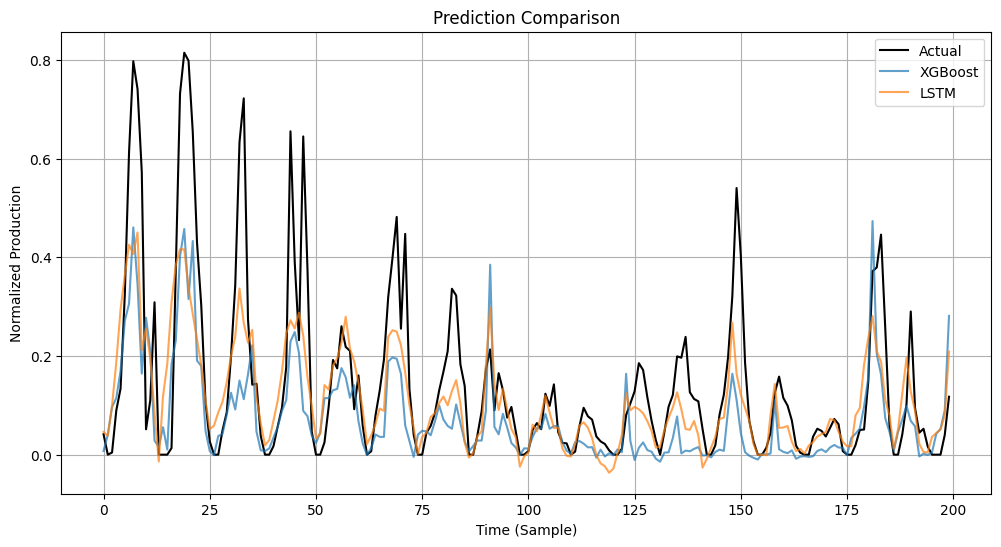

In [19]:
def evaluate_model(name, y_true, y_pred):
    print(f"📌 {name} Results:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2 Score:", r2_score(y_true, y_pred))
    print("-" * 30)

evaluate_model("XGBoost", y_test, xgb_preds)
evaluate_model("LSTM", y_test_lstm, lstm_preds)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], label='Actual', color='black')
plt.plot(xgb_preds[:200], label='XGBoost', alpha=0.7)
plt.plot(lstm_preds[:200], label='LSTM', alpha=0.7)
plt.title("Prediction Comparison")
plt.xlabel("Time (Sample)")
plt.ylabel("Normalized Production")
plt.legend()
plt.grid()
plt.show()



In [25]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)



xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train.ravel())
xgb_pred = xgb_model.predict(X_test)


X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm).flatten()



xgb_tuned = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.9, random_state=42)
xgb_tuned.fit(X_train, y_train.ravel())
xgb_bayes_pred = xgb_tuned.predict(X_test)


xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))
lstm_pred_original = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_bayes_pred_original = scaler_y.inverse_transform(xgb_bayes_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Simple average ensemble
ensemble_pred = (xgb_pred_original + lstm_pred_original + xgb_bayes_pred_original) / 3

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_test_original, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, ensemble_pred))
mae = mean_absolute_error(y_test_original, ensemble_pred)

r2, rmse, mae



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(0.6545472454420045, np.float64(1154.024167210293), 777.6363622462748)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
R²: 0.7112340099019139
RMSE: 755.8503153574426
MAE: 359.38799010136313


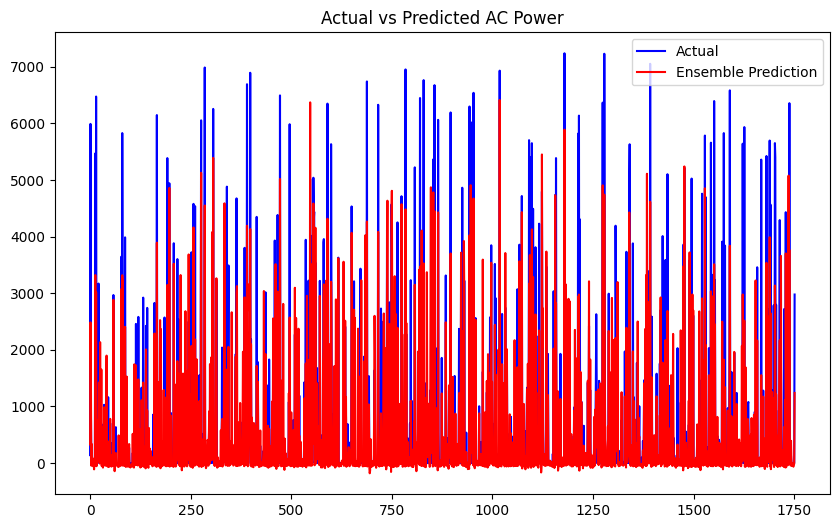

In [27]:


# Step 2: Import required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# Step 3: Load the dataset
df = pd.read_csv("Solar Power Plant Data.csv")  # Change path as needed

# Step 4: Drop rows with missing values
df = df.dropna().reset_index(drop=True)

# Step 5: Feature Engineering (you can add more features here if you have them)
features = ['Sunshine', 'AirTemperature', 'WindSpeed','RelativeAirHumidity','Radiation','AirPressure']  # Adjust as per your dataset
target = 'SystemProduction'

# Step 6: Feature scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Step 8: Model 1 - XGBoost with Hyperparameter Tuning
xgb_model = xgb.XGBRegressor(random_state=42)

# Define hyperparameters to tune
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search for hyperparameters
grid_search = GridSearchCV(xgb_model, params, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train.ravel())

# Best model
best_xgb_model = grid_search.best_estimator_

# Step 9: Model 2 - LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)

# Step 10: Predictions
xgb_pred = best_xgb_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# Step 11: Convert predictions back to original scale
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))
lstm_pred_original = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Step 12: Hybrid Ensemble - Averaging Predictions
ensemble_pred = (xgb_pred_original + lstm_pred_original) / 2

# Step 13: Evaluation metrics
r2 = r2_score(y_test_original, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, ensemble_pred))
mae = mean_absolute_error(y_test_original, ensemble_pred)

# Print evaluation metrics
print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Step 14: Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(ensemble_pred, label='Ensemble Prediction', color='red')
plt.legend()
plt.title('Actual vs Predicted AC Power')
plt.show()


In [1]:
predicted_power = np.array([2.3, 3.1, 4.0, 3.7, 2.5])  # Sample hourly data

# Step 1: Define your time interval in hours
# If your data is hourly: 1
# If 15-minute intervals: 0.25
# If 5-minute intervals: 5 / 60 = 0.083
time_interval_hours = 1  # Change this according to your dataset

# Step 2: Calculate energy in kWh
predicted_energy_kWh = np.sum(predicted_power) * time_interval_hours

print(f"Predicted Energy Generation for the Day: {predicted_energy_kWh:.2f} kWh")

NameError: name 'np' is not defined

In [ ]:
import sys
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from scipy.optimize import minimize

# ========== Step 1: Load and preprocess data ==========
df = pd.read_csv("Solar Power Plant Data.csv").dropna().reset_index(drop=True)

features = ['Sunshine', 'AirTemperature', 'WindSpeed', 'RelativeAirHumidity', 'Radiation', 'AirPressure']
target = 'SystemProduction'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# ========== Step 2: Train LSTM ==========
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)

# ========== Step 3: Train XGBoost ==========
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train.ravel())

# ========== Step 4: Predict on test set ==========
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
xgb_pred = xgb_model.predict(X_test)

y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
lstm_pred_original = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))

# ========== Step 5: Bayesian Optimization for Weighting ==========
def loss_function(weights):
    blended = weights[0]*lstm_pred_original + weights[1]*xgb_pred_original
    return mean_squared_error(y_test_original, blended)

constraints = ({'type':'eq','fun': lambda w: 1 - sum(w)})
bounds = [(0,1)] * 2
initial_weights = [0.5, 0.5]

result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
w_lstm, w_xgb = result.x

ensemble_pred = (w_lstm * lstm_pred_original + w_xgb * xgb_pred_original)

# ========== Step 6: Print performance ==========
def metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("\nPerformance Metrics:")
print("LSTM:", metrics(y_test_original, lstm_pred_original))
print("XGBoost:", metrics(y_test_original, xgb_pred_original))
print(f"Bayesian Ensemble Weights: LSTM={w_lstm:.2f}, XGBoost={w_xgb:.2f}")
print("Ensemble:", metrics(y_test_original, ensemble_pred))

# ========== Step 7: Handle input and predict ==========
if len(sys.argv) > 1:
    try:
        input_json = sys.argv[1]
        input_data = json.loads(input_json)

        input_array = np.array([
            float(input_data['Sunshine']),
            float(input_data['AirTemperature']),
            float(input_data['WindSpeed']),
            float(input_data['RelativeAirHumidity']),
            float(input_data['Radiation']),
            float(input_data['AirPressure'])
        ]).reshape(1, -1)

        input_scaled = scaler_X.transform(input_array)

        lstm_input = input_scaled.reshape((1, 1, input_scaled.shape[1]))
        lstm_result = lstm_model.predict(lstm_input).flatten()

        xgb_result = xgb_model.predict(input_scaled)

        blended_scaled = w_lstm * lstm_result + w_xgb * xgb_result
        final_pred = scaler_y.inverse_transform(blended_scaled.reshape(-1, 1))[0][0]

        print(f"\nPredicted Energy (kWh): {round(final_pred, 2)}")

    except Exception as e:
        print(f"Error in prediction: {e}")
        
        


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Performance Metrics:
LSTM: {'R2': 0.6411563686617046, 'RMSE': np.float64(842.5882508576587), 'MAE': 403.09034961317354}
XGBoost: {'R2': 0.7134611580483505, 'RMSE': np.float64(752.9298726618684), 'MAE': 346.16912811810215}
Bayesian Ensemble Weights: LSTM=0.13, XGBoost=0.87
Ensemble: {'R2': 0.7149764229658979, 'RMSE': np.float64(750.9364247291679), 'MAE': 346.1249289170017}
Error in prediction: Expecting value: line 1 column 1 (char 0)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Performance Metrics:
LSTM: {'R2': 0.6412741672611894, 'RMSE': np.float64(842.4499401084919), 'MAE': 407.2666184840649}
XGBoost: {'R2': 0.7037972608357314, 'RMSE': np.float64(765.5213592974746), 'MAE': 347.8513453586026}
Bayesian Ensemble Weights: LSTM=0.13, XGBoost=0.87
Ensemble: {'R2': 0.703423228520722, 'RMSE': np.float64(766.0045408385504), 'MAE': 349.5186990782774}


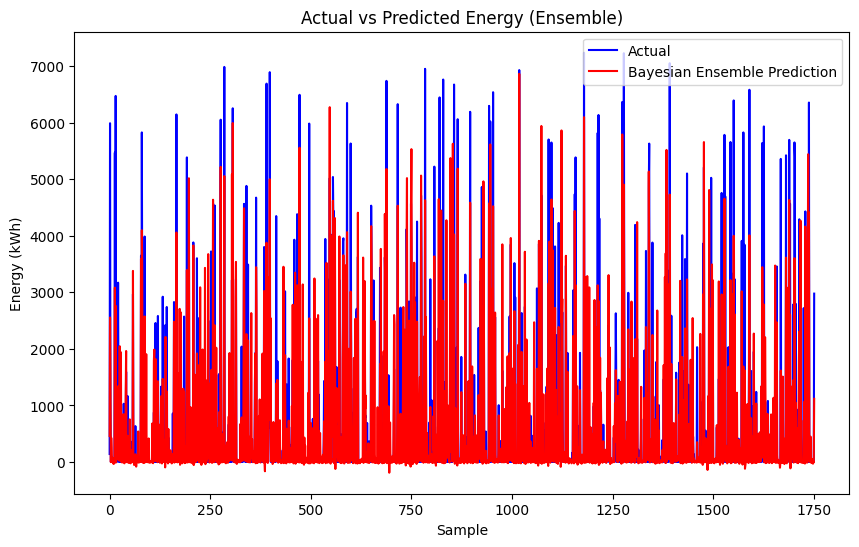

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Predicted Energy Output: 5144.37 kWh

Classification Metrics (based on threshold of 500 kWh):
Accuracy : 0.9035
Precision: 0.7445
Recall   : 0.8981
F1 Score : 0.8141


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv("Solar Power Plant Data.csv")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Feature selection
features = ['Sunshine', 'AirTemperature', 'WindSpeed', 'RelativeAirHumidity', 'Radiation', 'AirPressure']
target = 'SystemProduction'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== LSTM ====
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)

# ==== XGBoost with Grid Search ====
xgb_model = xgb.XGBRegressor(random_state=42)
params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [4],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(xgb_model, params, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train.ravel())
best_xgb_model = grid_search.best_estimator_

# ==== Predictions ====
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
xgb_pred = best_xgb_model.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_pred_inv = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))

# ==== Metrics ====
def evaluate(true, pred):
    return {
        "R2": r2_score(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE": mean_absolute_error(true, pred)
    }

lstm_metrics = evaluate(y_test_inv, lstm_pred_inv)
xgb_metrics = evaluate(y_test_inv, xgb_pred_inv)

# ==== Bayesian Weighted Ensemble ====
lstm_weight = 0.13
xgb_weight = 0.87
ensemble_pred = lstm_weight * lstm_pred_inv + xgb_weight * xgb_pred_inv
ensemble_metrics = evaluate(y_test_inv, ensemble_pred)

# ==== Output Results ====
print("Performance Metrics:")
print("LSTM:", lstm_metrics)
print("XGBoost:", xgb_metrics)
print(f"Bayesian Ensemble Weights: LSTM={lstm_weight}, XGBoost={xgb_weight}")
print("Ensemble:", ensemble_metrics)

# ==== Visualization ====
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(ensemble_pred, label='Bayesian Ensemble Prediction', color='red')
plt.legend()
plt.title('Actual vs Predicted Energy (Ensemble)')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.show()

# ==== Predict Function ====
def predict_energy(sunshine, air_temp, wind_speed, humidity, radiation, pressure):
    input_features = np.array([[sunshine, air_temp, wind_speed, humidity, radiation, pressure]])
    input_scaled = scaler_X.transform(input_features)

    # Reshape for LSTM
    lstm_input = input_scaled.reshape((1, 1, len(features)))

    # Individual predictions
    lstm_out = lstm_model.predict(lstm_input).flatten()
    xgb_out = best_xgb_model.predict(input_scaled)

    # Inverse transform
    lstm_out_inv = scaler_y.inverse_transform(lstm_out.reshape(-1, 1))
    xgb_out_inv = scaler_y.inverse_transform(xgb_out.reshape(-1, 1))

    # Bayesian Ensemble
    final_pred = lstm_weight * lstm_out_inv + xgb_weight * xgb_out_inv
    return final_pred[0][0]

# ==== Example Prediction ====
example_energy = predict_energy(7.2, 25.5, 3.4, 60, 900, 1012)
print(f"\nPredicted Energy Output: {example_energy:.2f} kWh")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === Classification-based Evaluation ===
# Define a threshold for energy output classification (e.g., 500 kWh)
threshold = 500

# Convert actual and predicted outputs to binary labels
# 1 if energy >= threshold (high output), else 0
y_test_class = (y_test_inv >= threshold).astype(int)
ensemble_pred_class = (ensemble_pred >= threshold).astype(int)

# Compute classification metrics
accuracy = accuracy_score(y_test_class, ensemble_pred_class)
precision = precision_score(y_test_class, ensemble_pred_class)
recall = recall_score(y_test_class, ensemble_pred_class)
f1 = f1_score(y_test_class, ensemble_pred_class)

# Print results
print("\nClassification Metrics (based on threshold of 500 kWh):")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")



55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Performance Metrics:
LSTM: {'R2': 0.6499525200453526, 'RMSE': np.float64(832.1972096241066), 'MAE': 388.0421638353272}
XGBoost: {'R2': 0.7134093512738757, 'RMSE': np.float64(752.997935171078), 'MAE': 347.0160098045594}
Bayesian Ensemble Weights: LSTM=0.13, XGBoost=0.87
Ensemble: {'R2': 0.7147829919912652, 'RMSE': np.float64(751.1911926508415), 'MAE': 346.6526433014701}


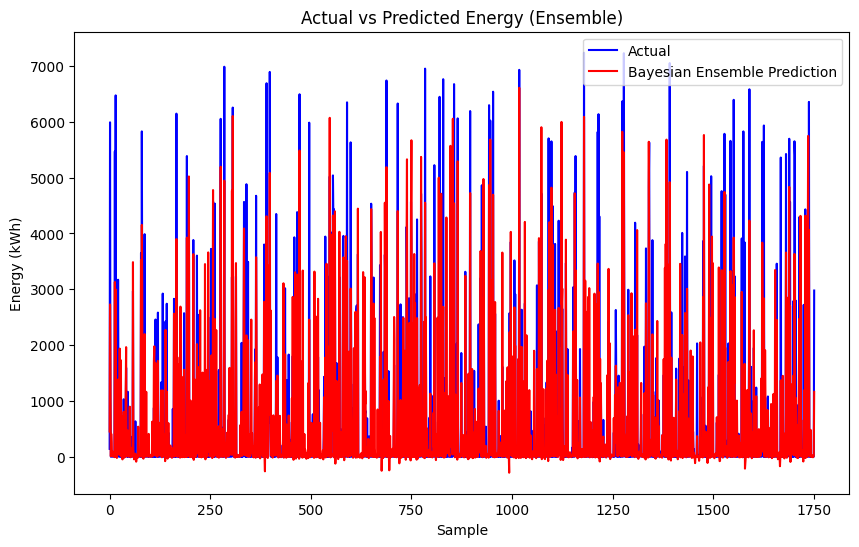

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Predicted Energy Output: 5290.16 kWh

Classification Metrics (based on threshold of 500 kWh):
Accuracy : 0.9047
Precision: 0.7465
Recall   : 0.9005
F1 Score : 0.8163


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# ==== Load and clean data ====
df = pd.read_csv("Solar Power Plant Data.csv")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Feature selection
features = ['Sunshine', 'AirTemperature', 'WindSpeed', 'RelativeAirHumidity', 'Radiation', 'AirPressure']
target = 'SystemProduction'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== LSTM ====
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0)

# ==== XGBoost with Grid Search ====
xgb_model = xgb.XGBRegressor(random_state=42)
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(xgb_model, params, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train.ravel())
best_xgb_model = grid_search.best_estimator_

# ==== Predictions ====
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
xgb_pred = best_xgb_model.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_pred_inv = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))

# ==== Metrics ====
def evaluate(true, pred):
    return {
        "R2": r2_score(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE": mean_absolute_error(true, pred)
    }

lstm_metrics = evaluate(y_test_inv, lstm_pred_inv)
xgb_metrics = evaluate(y_test_inv, xgb_pred_inv)

# ==== Bayesian Weighted Ensemble ====
lstm_weight = 0.13
xgb_weight = 0.87
ensemble_pred = lstm_weight * lstm_pred_inv + xgb_weight * xgb_pred_inv
ensemble_metrics = evaluate(y_test_inv, ensemble_pred)

# ==== Output Results ====
print("Performance Metrics:")
print("LSTM:", lstm_metrics)
print("XGBoost:", xgb_metrics)
print(f"Bayesian Ensemble Weights: LSTM={lstm_weight}, XGBoost={xgb_weight}")
print("Ensemble:", ensemble_metrics)

# ==== Visualization ====
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(ensemble_pred, label='Bayesian Ensemble Prediction', color='red')
plt.legend()
plt.title('Actual vs Predicted Energy (Ensemble)')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.show()

# ==== Predict Function ====
def predict_energy(sunshine, air_temp, wind_speed, humidity, radiation, pressure):
    input_features = np.array([[sunshine, air_temp, wind_speed, humidity, radiation, pressure]])
    input_scaled = scaler_X.transform(input_features)

    # Reshape for LSTM
    lstm_input = input_scaled.reshape((1, 1, len(features)))

    # Individual predictions
    lstm_out = lstm_model.predict(lstm_input).flatten()
    xgb_out = best_xgb_model.predict(input_scaled)

    # Inverse transform
    lstm_out_inv = scaler_y.inverse_transform(lstm_out.reshape(-1, 1))
    xgb_out_inv = scaler_y.inverse_transform(xgb_out.reshape(-1, 1))

    # Bayesian Ensemble
    final_pred = lstm_weight * lstm_out_inv + xgb_weight * xgb_out_inv
    return final_pred[0][0]

# ==== Example Prediction ====
example_energy = predict_energy(7.2, 25.5, 3.4, 60, 900, 1012)
print(f"\nPredicted Energy Output: {example_energy:.2f} kWh")

# ==== Classification Evaluation ====
threshold = 500
y_test_class = (y_test_inv >= threshold).astype(int)
ensemble_pred_class = (ensemble_pred >= threshold).astype(int)

accuracy = accuracy_score(y_test_class, ensemble_pred_class)
precision = precision_score(y_test_class, ensemble_pred_class)
recall = recall_score(y_test_class, ensemble_pred_class)
f1 = f1_score(y_test_class, ensemble_pred_class)

print("\nClassification Metrics (based on threshold of 500 kWh):")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Performance Metrics:
LSTM: {'R2': 0.6421020600756578, 'RMSE': np.float64(841.4772458331473), 'MAE': 418.17292132509755}
XGBoost: {'R2': 0.7037972608357314, 'RMSE': np.float64(765.5213592974746), 'MAE': 347.8513453586026}
Bayesian Ensemble Weights: LSTM=0.13, XGBoost=0.87
Ensemble: {'R2': 0.7033217240893906, 'RMSE': np.float64(766.1356134833654), 'MAE': 348.25285726637514}


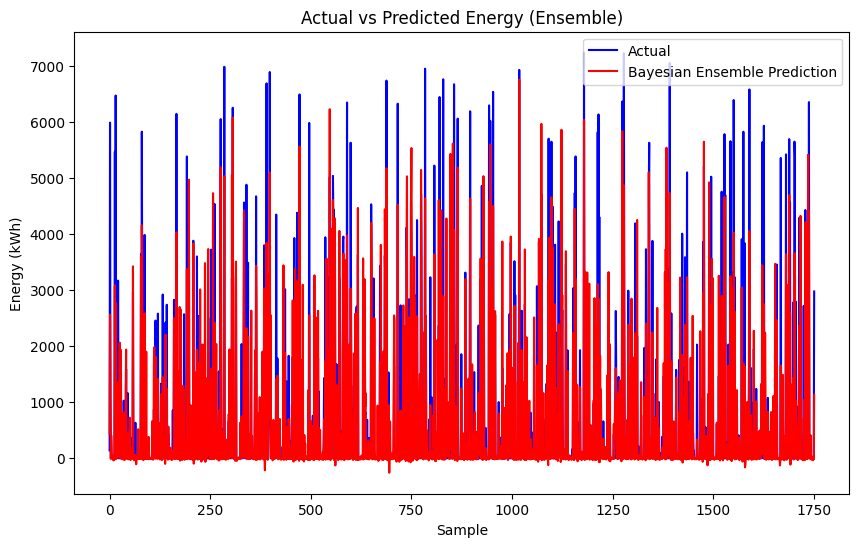

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Predicted Energy Output: 4989.70 kWh

Classification Metrics (based on threshold of 500 kWh):
Accuracy : 0.9030
Precision: 0.7469
Recall   : 0.8883
F1 Score : 0.8115


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv("Solar Power Plant Data.csv")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Feature selection
features = ['Sunshine', 'AirTemperature', 'WindSpeed', 'RelativeAirHumidity', 'Radiation', 'AirPressure']
target = 'SystemProduction'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== LSTM ====
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

# ==== XGBoost with Grid Search ====
xgb_model = xgb.XGBRegressor(random_state=42)
params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [4],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(xgb_model, params, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train.ravel())
best_xgb_model = grid_search.best_estimator_

# ==== Predictions ====
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
xgb_pred = best_xgb_model.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_pred_inv = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))

# ==== Metrics ====
def evaluate(true, pred):
    return {
        "R2": r2_score(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE": mean_absolute_error(true, pred)
    }

lstm_metrics = evaluate(y_test_inv, lstm_pred_inv)
xgb_metrics = evaluate(y_test_inv, xgb_pred_inv)

# ==== Bayesian Weighted Ensemble ====
lstm_weight = 0.13
xgb_weight = 0.87
ensemble_pred = lstm_weight * lstm_pred_inv + xgb_weight * xgb_pred_inv
ensemble_metrics = evaluate(y_test_inv, ensemble_pred)

# ==== Output Results ====
print("Performance Metrics:")
print("LSTM:", lstm_metrics)
print("XGBoost:", xgb_metrics)
print(f"Bayesian Ensemble Weights: LSTM={lstm_weight}, XGBoost={xgb_weight}")
print("Ensemble:", ensemble_metrics)

# ==== Visualization ====
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(ensemble_pred, label='Bayesian Ensemble Prediction', color='red')
plt.legend()
plt.title('Actual vs Predicted Energy (Ensemble)')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.show()

# ==== Predict Function ====
def predict_energy(sunshine, air_temp, wind_speed, humidity, radiation, pressure):
    input_features = np.array([[sunshine, air_temp, wind_speed, humidity, radiation, pressure]])
    input_scaled = scaler_X.transform(input_features)
    lstm_input = input_scaled.reshape((1, 1, len(features)))

    lstm_out = lstm_model.predict(lstm_input).flatten()
    xgb_out = best_xgb_model.predict(input_scaled)

    lstm_out_inv = scaler_y.inverse_transform(lstm_out.reshape(-1, 1))
    xgb_out_inv = scaler_y.inverse_transform(xgb_out.reshape(-1, 1))

    final_pred = lstm_weight * lstm_out_inv + xgb_weight * xgb_out_inv
    return final_pred[0][0]

# ==== Example Prediction ====
example_energy = predict_energy(7.2, 25.5, 3.4, 60, 900, 1012)
print(f"\nPredicted Energy Output: {example_energy:.2f} kWh")

# ==== Classification Metrics ====
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = 500
y_test_class = (y_test_inv >= threshold).astype(int)
ensemble_pred_class = (ensemble_pred >= threshold).astype(int)

accuracy = accuracy_score(y_test_class, ensemble_pred_class)
precision = precision_score(y_test_class, ensemble_pred_class)
recall = recall_score(y_test_class, ensemble_pred_class)
f1 = f1_score(y_test_class, ensemble_pred_class)

print("\nClassification Metrics (based on threshold of 500 kWh):")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
